In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast/uncertainty


In [2]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from IPython.display import clear_output
import pickle
import time

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU
from tensorflow.keras.layers import Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Reshape, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import BatchCreator, Logger
from feature_extraction import simple_fe
from model_builder import get_pinball_losses, get_simple_dist_model, get_simple_dense_model
from flow import (model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model,
                  restore_tags_converted_sales, read_converted_sales)

# import functions from https://www.kaggle.com/robertburbidge/lightgbm-poisson-w-scaled-pinball-loss
from lightgbm_kernel import (reduce_mem_usage, read_data, encode_categorical, \
                            weight_calc, make_wrmsse, agg_series)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Any results you write to the current directory are saved as output.

data/.DS_Store
data/empty_pred.csv
data/pred_skeleton.csv
data/calendar.csv
data/sales_train_money.csv
data/sell_prices.csv
data/sales_train_validation.csv
data/sample_submission.csv
data/prep/converted_sales_level_12.csv
data/prep/converted_sales_level_11.csv
data/prep/converted_sales_level_10.csv
data/prep/converted_sales_all.csv
data/prep/norm_level_11.csv
data/prep/.DS_Store
data/prep/norm_level_10.csv
data/prep/norm_level_12.csv
data/prep/level_3_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle
data/prep/level_9_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle
data/prep/norm_level_1.csv
data/prep/level_12_simple_fe_2014_04_26_2016_04_24_normalised_demand.pickle
data/prep/norm_level_2.csv
data/prep/norm_level_3.csv
data/prep/norm_level_7.csv
data/prep/norm_level_6.csv
data/prep/converted_sales_level_9.csv
data/prep/norm_level_4.csv
data/prep/norm_level_5.csv
data/prep/converted_sales_level_8.csv
data/prep/converted_sales_level_5.csv
data/prep/norm_level_8.csv
data/p

# Optimise MLP - level 9

In [4]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
level = 9

model_dir = 'models/uncertainty/hyper_opt/level_{}/'.format(level)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

categorical_features = {
    1: [],
    2: ['state_id'],
    3: ['state_id', 'store_id'],
    4: ['cat_id'],
    5: ['cat_id', 'dept_id'],
    6: ['state_id', 'cat_id'],
    7: ['state_id', 'cat_id', 'dept_id'],
    8: ['state_id', 'store_id', 'dept_id'],
    9: ['state_id', 'store_id', 'cat_id', 'dept_id'],
    10: ['cat_id', 'dept_id', 'item_id'],
    11: ['state_id', 'cat_id', 'dept_id', 'item_id'],
    12: ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id'],
}

## Data preparation (or read saved result)
From `lightgbm-poisson-w-scaled-pinball-loss.ipynb`.  

+ swapperooni with normalised sales. 

Note: categorical features are converted to one-hot encoding by the BatchCreator to reduce memory usage. 

In [7]:
# read data for pipeline from lightgbm-poisson-w-scaled-pinball-loss.ipynb
calendar, sell_prices, sales_train_val, submission = read_data() # with memory reduction

# read comverted sales
converted_sales = read_converted_sales(level=level, data_dir=data_dir)

### Replace demand with normalised sales
sales_train_val = converted_sales

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Mem. usage decreased to  0.26 Mb (74.8% reduction)


In [8]:
NUM_ITEMS = sales_train_val.shape[0]  # 1 / ... / 70 / ... / 30,240
DAYS_PRED = submission.shape[1] - 1   # 28
print(NUM_ITEMS, DAYS_PRED)

70 28


In [9]:
if level <= 9:
    nrows = 365 * 6 * NUM_ITEMS  # all
else:
    nrows = 365 * 2 * NUM_ITEMS

In [10]:
calendar = encode_categorical(
    calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales_train_val = encode_categorical(
    sales_train_val, categorical_features[level],
).pipe(reduce_mem_usage)

sell_prices = encode_categorical(sell_prices, ["item_id", "store_id"]).pipe(
    reduce_mem_usage
)

Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to  0.26 Mb (0.7% reduction)
Mem. usage decreased to 45.67 Mb (65.0% reduction)


In [11]:
sales_train_val = pd.melt(sales_train_val,
                          id_vars = ['id', *categorical_features[level]],
                          var_name = 'day', value_name = 'demand')
print('Melted sales train validation has {} rows and {} columns'.format(*sales_train_val.shape))
sales_train_val.head()

Melted sales train validation has 133910 rows and 7 columns


,id,state_id,store_id,cat_id,dept_id,day,demand
0,CA_1_FOODS_1,0,0,0,0,d_1,0.039917
1,CA_1_FOODS_2,0,0,0,1,d_1,0.157349
2,CA_1_FOODS_3,0,0,0,2,d_1,0.332275
3,CA_1_HOBBIES_1,0,0,1,3,d_1,0.128662
4,CA_1_HOBBIES_2,0,0,1,4,d_1,0.002232


In [12]:
print("Selecting {} rows ({:.1%})".format(nrows, nrows/sales_train_val.index.size))
data = sales_train_val.iloc[-nrows:,:]

Selecting 153300 rows (114.5%)


In [13]:
#calendarの結合
# drop some calendar features(不要な変数の削除:weekdayやwdayなどはdatetime変数から後ほど作成できる。)
calendar.drop(['weekday', 'wday', 'month', 'year'],
              inplace = True, axis = 1)

# notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)(dayとdをキーにdataに結合)
data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
data.drop(['d', 'day'], inplace = True, axis = 1)

# add sell price if all of the columns 'store_id', 'item_id', 'wm_yr_wk' are available
#sell price
if np.prod([col in data.columns for col in ['store_id', 'item_id', 'wm_yr_wk']]):
    # get the sell price data (this feature should be very important)
    data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
    print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))

# memory
del sell_prices
gc.collect()

40

In [14]:
data = reduce_mem_usage(simple_fe(data, DAYS_PRED=DAYS_PRED))

Mem. usage decreased to 11.11 Mb (0.0% reduction)


In [15]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [16]:
print("{:.2f} MB".format(data.memory_usage().sum() / 1024**2))

11.11 MB


### Save prepared dataset
Pickle chosen for its speed. See: https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d. 
Feather and parquet both require additional libraries (pyarrow). 

In [17]:
fn = data_dir + 'prep/level_{}_simple_fe_{}_{}_normalised_demand.pickle'.format(
    level, data.date.min().date().strftime("%Y_%m_%d"), data.date.max().date().strftime("%Y_%m_%d")
)
print("Saving to file..")
data.to_pickle(fn)
print("Finished.")

Saving to file..
Finished.


### Read prepared dataset

In [6]:
fn = data_dir + 'prep/level_{}_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle'.format(level)
data = pd.read_pickle(fn)

In [7]:
features = [
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    # demand features.
    "shift_t28",
    "shift_t29",
    "shift_t30",
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t60",
    "rolling_std_t90",
    "rolling_std_t180",
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    "rolling_skew_t30",
    "rolling_kurt_t30",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_year_end",
    "is_year_start",
    "is_quarter_end",
    "is_quarter_start",
    "is_month_end",
    "is_month_start",
    "is_weekend"
]

# add categorical features, based on availability
features += categorical_features[level]

# add price features, based on availability
if 'sell_price' in data.columns:
    features += [
        # price features
        "sell_price",
        "price_change_t1",
        "price_change_t365",
        "rolling_price_std_t7",
        "rolling_price_std_t30",
    ]

In [8]:
data.head()[features]

,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,shift_t28,shift_t29,shift_t30,...,is_year_start,is_quarter_end,is_quarter_start,is_month_end,is_month_start,is_weekend,state_id,store_id,cat_id,dept_id
0,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
1,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,1
2,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,2
3,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,1,3
4,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,1,4


In [95]:
cat_features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
]

available_cat_features = [f for f in cat_features if f in data.columns]
features += available_cat_features

for col in available_cat_features:
    data[col] = data[col].astype('category')

## BatchCreator

In [10]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [96]:
labels = ['demand']
batch_size = 25000#25000
train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                  batch_size=batch_size)
val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                 categorical_features=available_cat_features, batch_size=batch_size)

## Initialize pinball loss

In [97]:
losses = get_pinball_losses()

## Build model

### Train dense model

In [101]:
# create a batch to detect input shape
x, y = next(val_batch_creator.flow())

model = get_simple_dense_model(inp_shape=x[0].shape)
model.compile(optimizer=Adam(learning_rate=1e-5), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 369)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           23680       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [102]:
logger = Logger(val_batch_creator, model_dir=model_dir)

Tracking ['loss', 'q0_loss', 'q1_loss', 'q2_loss', 'q3_loss', 'q4_loss', 'q5_loss', 'q6_loss', 'q7_loss', 'q8_loss']
Tracking ['val_loss', 'val_q0_loss', 'val_q1_loss', 'val_q2_loss', 'val_q3_loss', 'val_q4_loss', 'val_q5_loss', 'val_q6_loss', 'val_q7_loss', 'val_q8_loss']


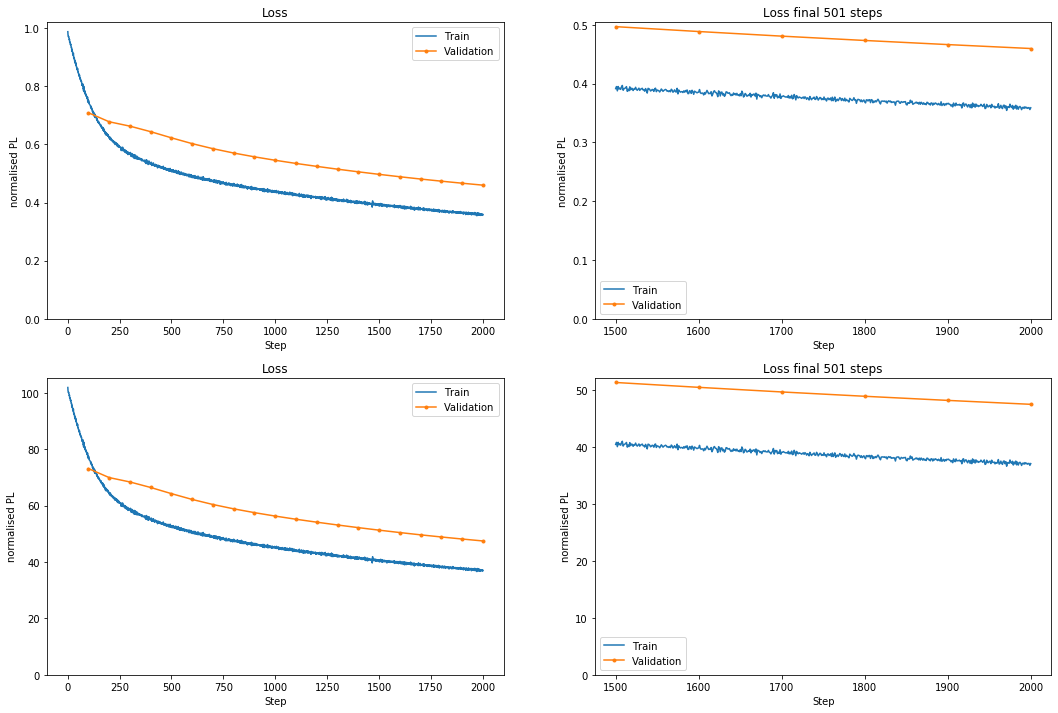

100/100 [==============================] - 37s 373ms/step - loss: 0.3616 - q0_loss: 0.0041 - q1_loss: 0.0036 - q2_loss: 0.0133 - q3_loss: 0.0316 - q4_loss: 0.0363 - q5_loss: 0.1530 - q6_loss: 0.0293 - q7_loss: 0.0710 - q8_loss: 0.0194 - val_loss: 0.4598 - val_q0_loss: 0.0028 - val_q1_loss: 0.0043 - val_q2_loss: 0.0140 - val_q3_loss: 0.0386 - val_q4_loss: 0.0453 - val_q5_loss: 0.1864 - val_q6_loss: 0.0417 - val_q7_loss: 0.0972 - val_q8_loss: 0.0295


In [103]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=20,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{9: 2.296219797933575, 'WSPL': 2.296219797933575}


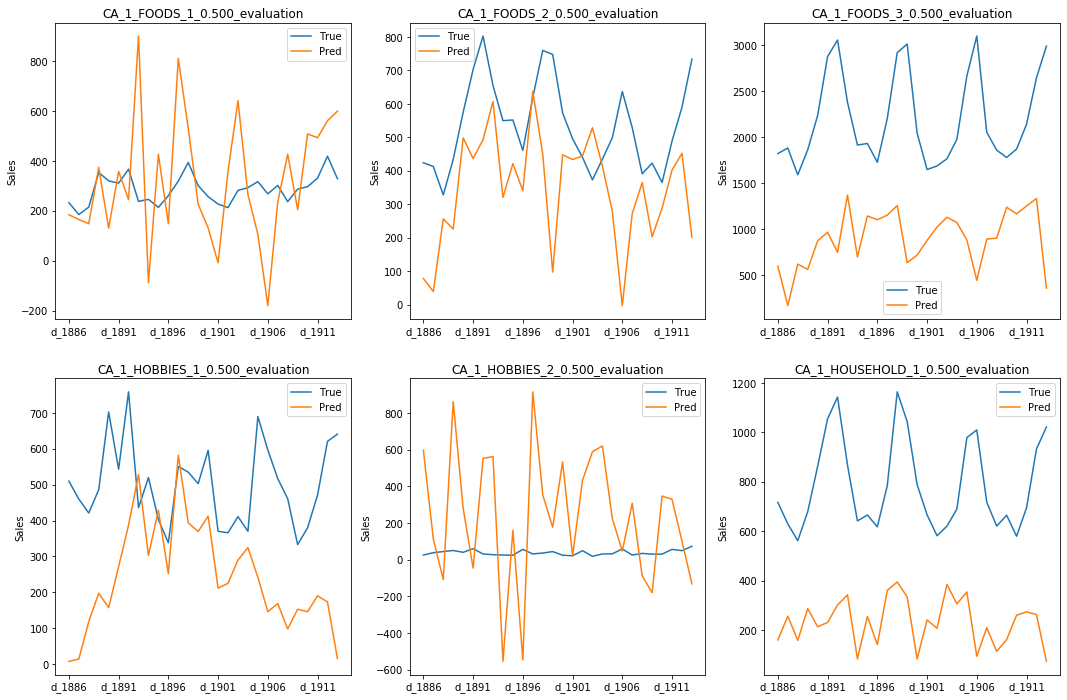

In [105]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

**Resume training with larger lr**

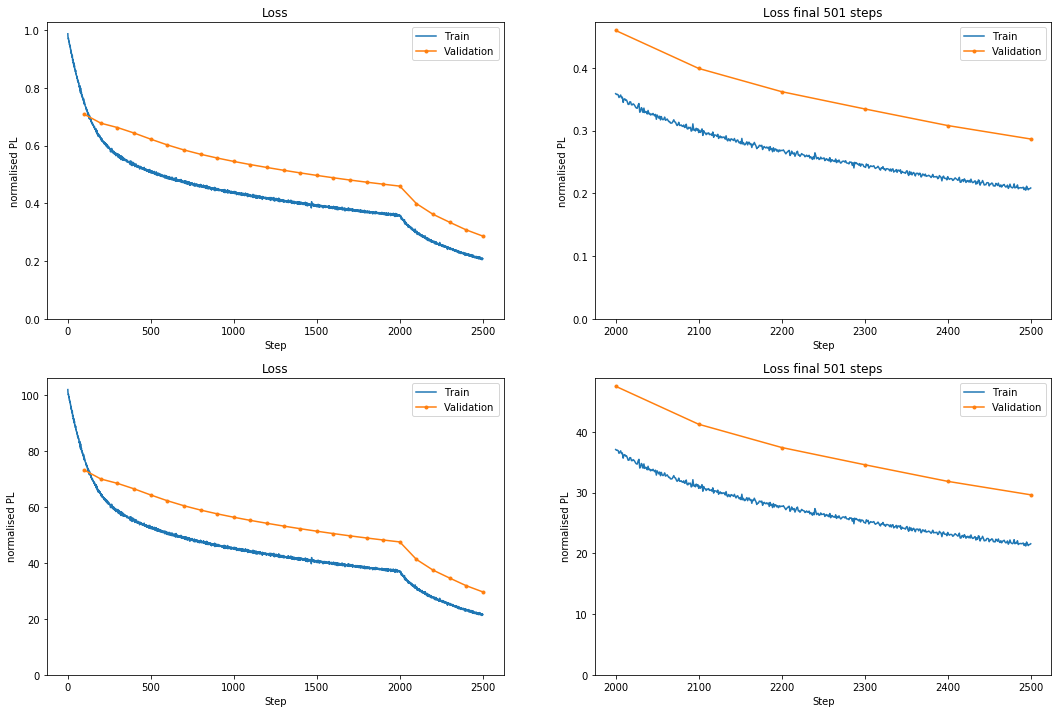

100/100 [==============================] - 35s 351ms/step - loss: 0.2153 - q0_loss: 0.0013 - q1_loss: 0.0029 - q2_loss: 0.0054 - q3_loss: 0.0270 - q4_loss: 0.0292 - q5_loss: 0.1141 - q6_loss: 0.0096 - q7_loss: 0.0230 - q8_loss: 0.0028 - val_loss: 0.2868 - val_q0_loss: 0.0017 - val_q1_loss: 0.0037 - val_q2_loss: 0.0061 - val_q3_loss: 0.0345 - val_q4_loss: 0.0368 - val_q5_loss: 0.1527 - val_q6_loss: 0.0121 - val_q7_loss: 0.0354 - val_q8_loss: 0.0038


In [107]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

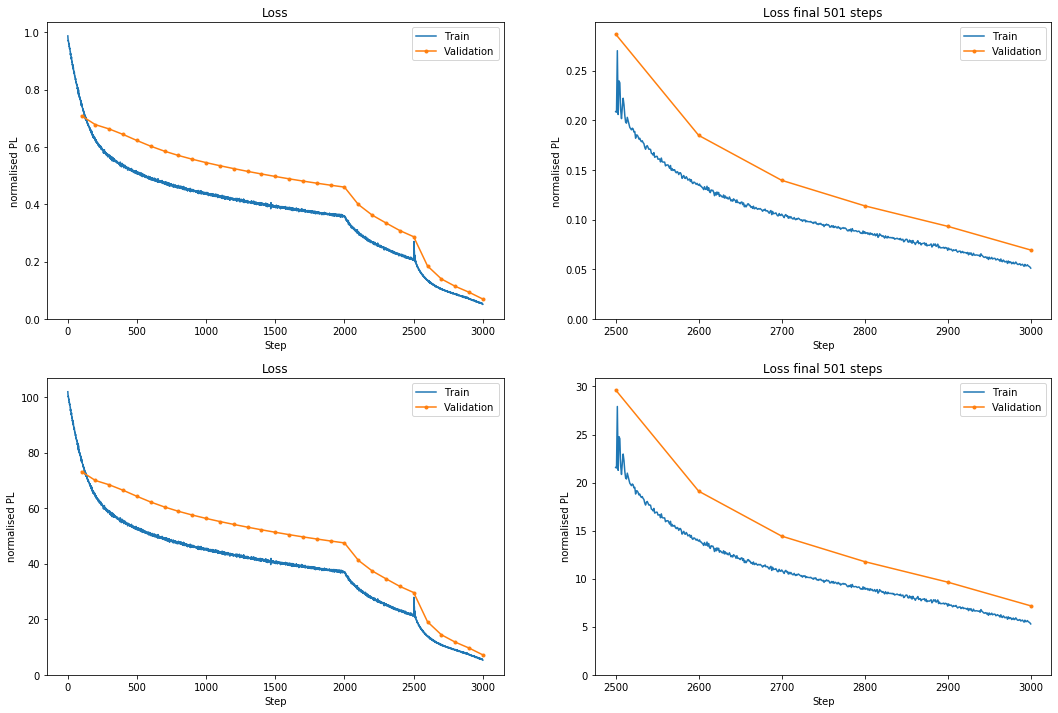

100/100 [==============================] - 35s 354ms/step - loss: 0.0615 - q0_loss: 0.0012 - q1_loss: 0.0031 - q2_loss: 0.0038 - q3_loss: 0.0053 - q4_loss: 0.0059 - q5_loss: 0.0175 - q6_loss: 0.0085 - q7_loss: 0.0157 - q8_loss: 6.5545e-04 - val_loss: 0.0695 - val_q0_loss: 0.0016 - val_q1_loss: 0.0038 - val_q2_loss: 0.0048 - val_q3_loss: 0.0056 - val_q4_loss: 0.0069 - val_q5_loss: 0.0168 - val_q6_loss: 0.0064 - val_q7_loss: 0.0230 - val_q8_loss: 6.1739e-04


In [108]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{9: 0.3468535511733928, 'WSPL': 0.3468535511733928}


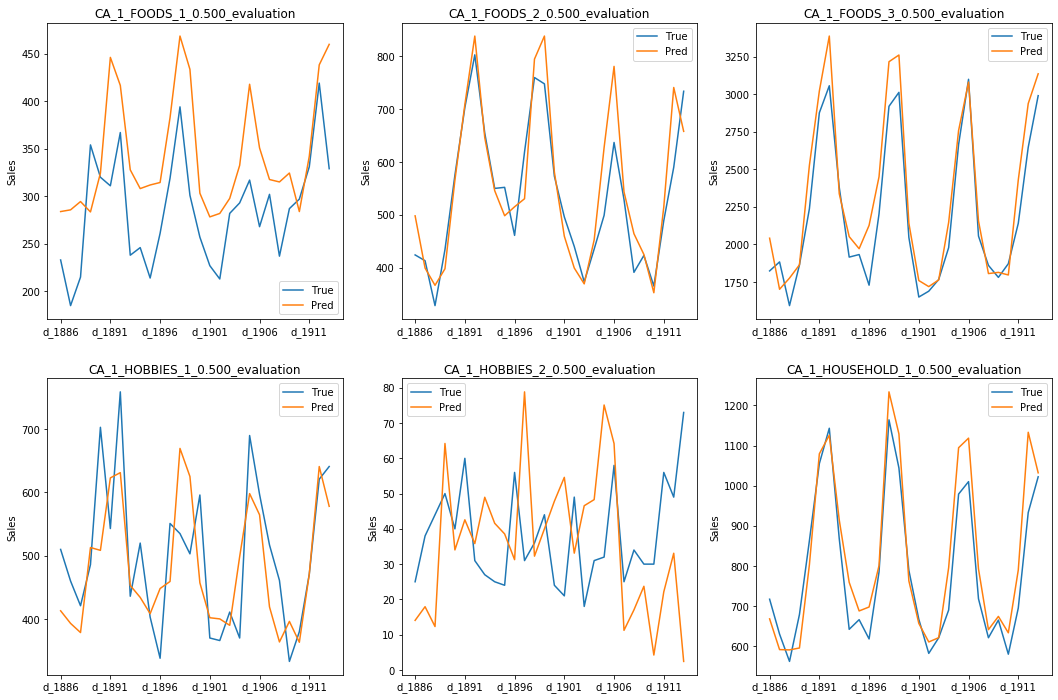

In [109]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

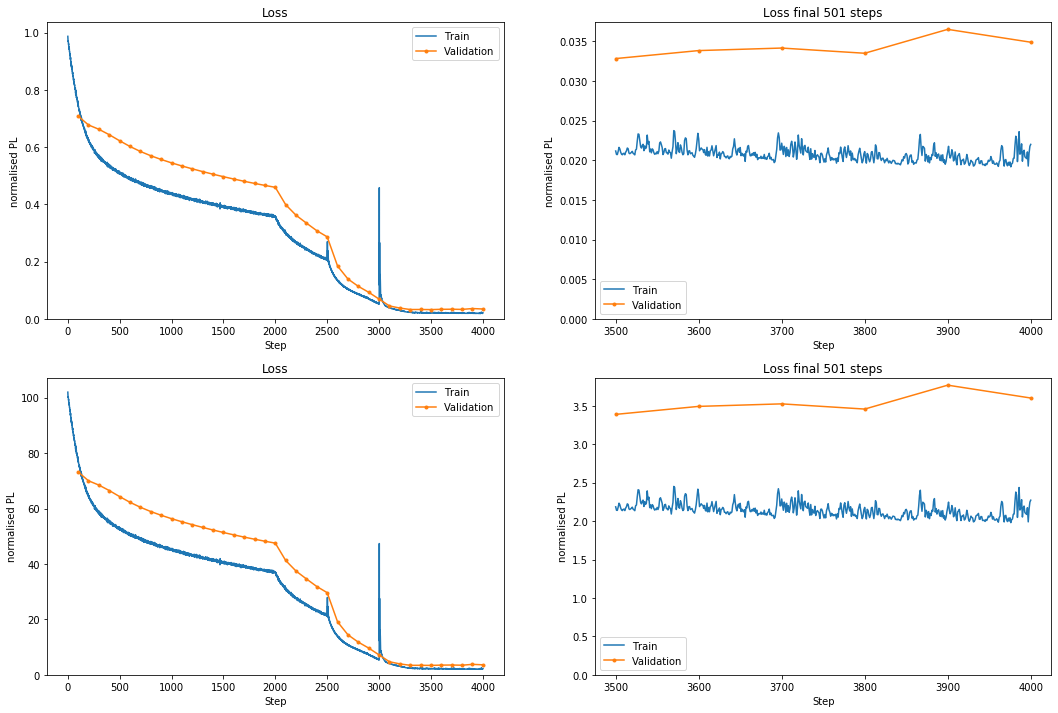

100/100 [==============================] - 36s 358ms/step - loss: 0.0202 - q0_loss: 8.5408e-04 - q1_loss: 7.0166e-04 - q2_loss: 0.0028 - q3_loss: 0.0035 - q4_loss: 0.0044 - q5_loss: 0.0038 - q6_loss: 0.0030 - q7_loss: 8.4324e-04 - q8_loss: 2.5613e-04 - val_loss: 0.0349 - val_q0_loss: 0.0011 - val_q1_loss: 0.0014 - val_q2_loss: 0.0053 - val_q3_loss: 0.0062 - val_q4_loss: 0.0076 - val_q5_loss: 0.0064 - val_q6_loss: 0.0051 - val_q7_loss: 0.0015 - val_q8_loss: 4.2084e-04


In [110]:
model.compile(optimizer=Adam(learning_rate=3e-3), loss=losses)
history = model.fit(train_batch_creator.flow(), epochs=10, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{9: 0.17416807870391673, 'WSPL': 0.17416807870391673}


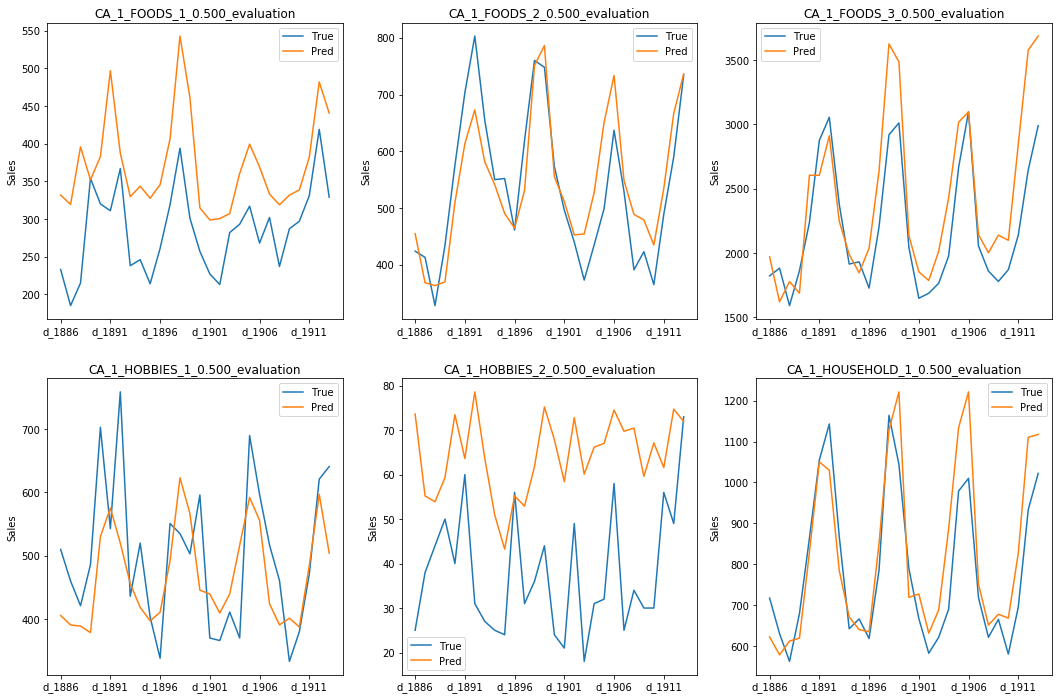

In [111]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

### Train dist model

In [114]:
# create a batch to detect input shape
x, y = next(val_batch_creator.flow())

model = get_simple_dist_model(inp_shape=x[0].shape)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 369)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           23680       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [115]:
logger3 = Logger(val_batch_creator)

Tracking ['loss', 'q0_loss', 'q1_loss', 'q2_loss', 'q3_loss', 'q4_loss', 'q5_loss', 'q6_loss', 'q7_loss', 'q8_loss']
Tracking ['val_loss', 'val_q0_loss', 'val_q1_loss', 'val_q2_loss', 'val_q3_loss', 'val_q4_loss', 'val_q5_loss', 'val_q6_loss', 'val_q7_loss', 'val_q8_loss']


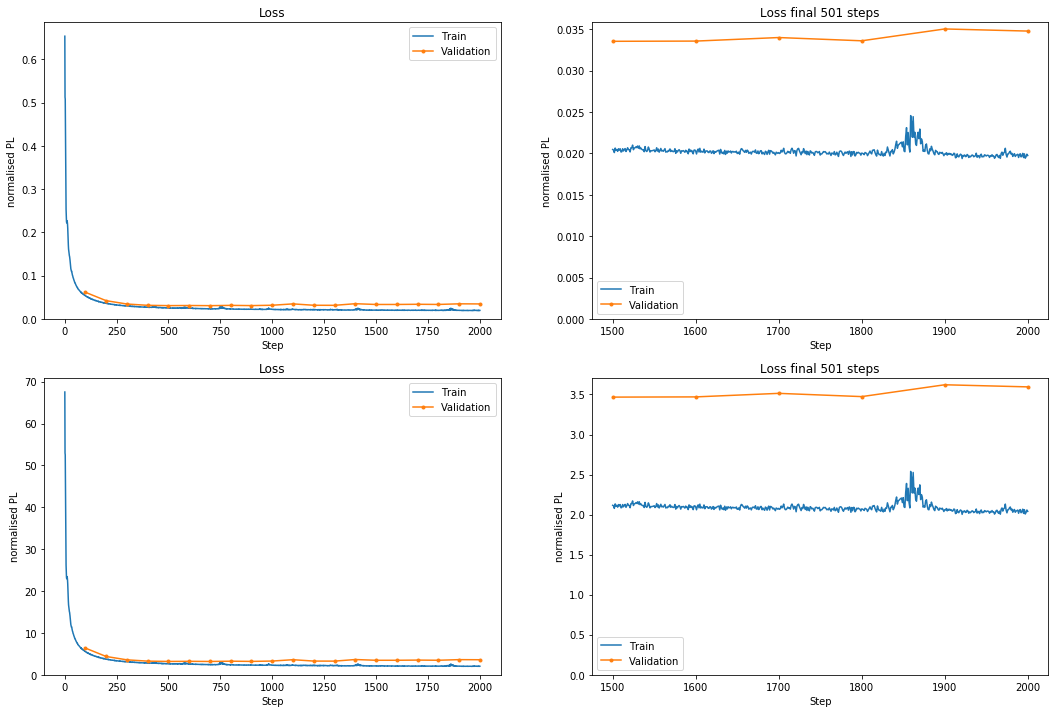

100/100 [==============================] - 42s 418ms/step - loss: 0.0198 - q0_loss: 1.8754e-04 - q1_loss: 6.9444e-04 - q2_loss: 0.0028 - q3_loss: 0.0036 - q4_loss: 0.0046 - q5_loss: 0.0038 - q6_loss: 0.0030 - q7_loss: 8.2375e-04 - q8_loss: 2.5592e-04 - val_loss: 0.0348 - val_q0_loss: 5.6389e-04 - val_q1_loss: 0.0016 - val_q2_loss: 0.0052 - val_q3_loss: 0.0064 - val_q4_loss: 0.0077 - val_q5_loss: 0.0063 - val_q6_loss: 0.0050 - val_q7_loss: 0.0015 - val_q8_loss: 5.9201e-04


In [116]:
history = model.fit(train_batch_creator.flow(), epochs=20,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger3])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{9: 0.1737764586092299, 'WSPL': 0.1737764586092299}


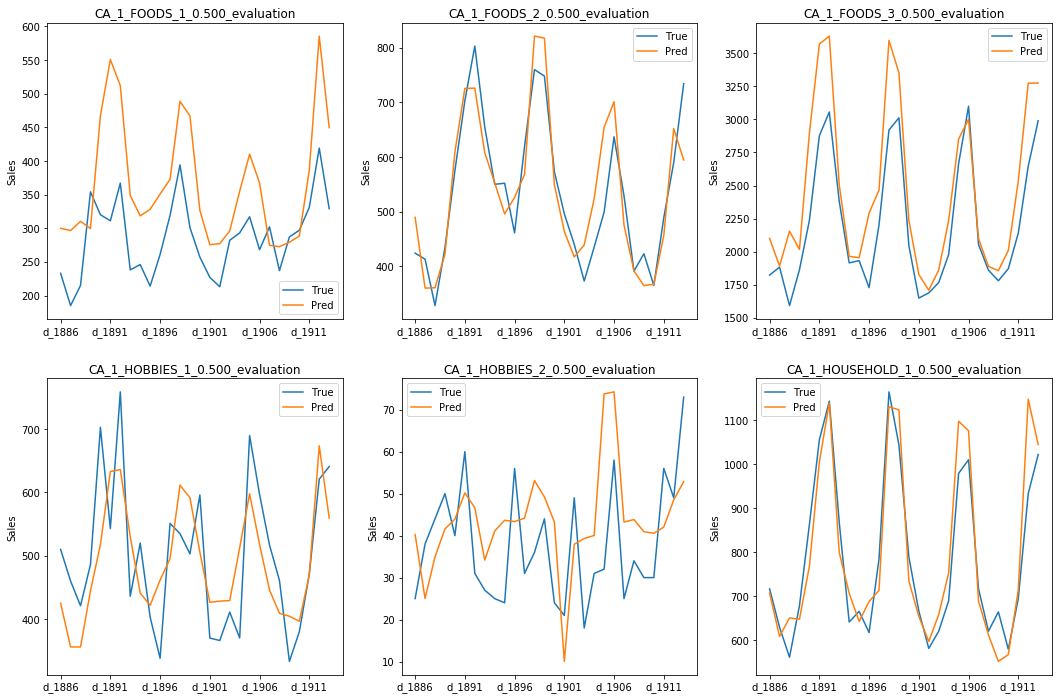

In [117]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

### Dist model with smaller batch size

In [122]:
labels = ['demand']
batch_size = 128#25000
train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                  batch_size=batch_size)
val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                 categorical_features=available_cat_features, batch_size=batch_size)

In [123]:
# create a batch to detect input shape
x, y = next(val_batch_creator.flow())

model = get_simple_dist_model(inp_shape=x[0].shape)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)

In [124]:
logger4 = Logger(val_batch_creator)

Tracking ['loss', 'q0_loss', 'q1_loss', 'q2_loss', 'q3_loss', 'q4_loss', 'q5_loss', 'q6_loss', 'q7_loss', 'q8_loss']
Tracking ['val_loss', 'val_q0_loss', 'val_q1_loss', 'val_q2_loss', 'val_q3_loss', 'val_q4_loss', 'val_q5_loss', 'val_q6_loss', 'val_q7_loss', 'val_q8_loss']


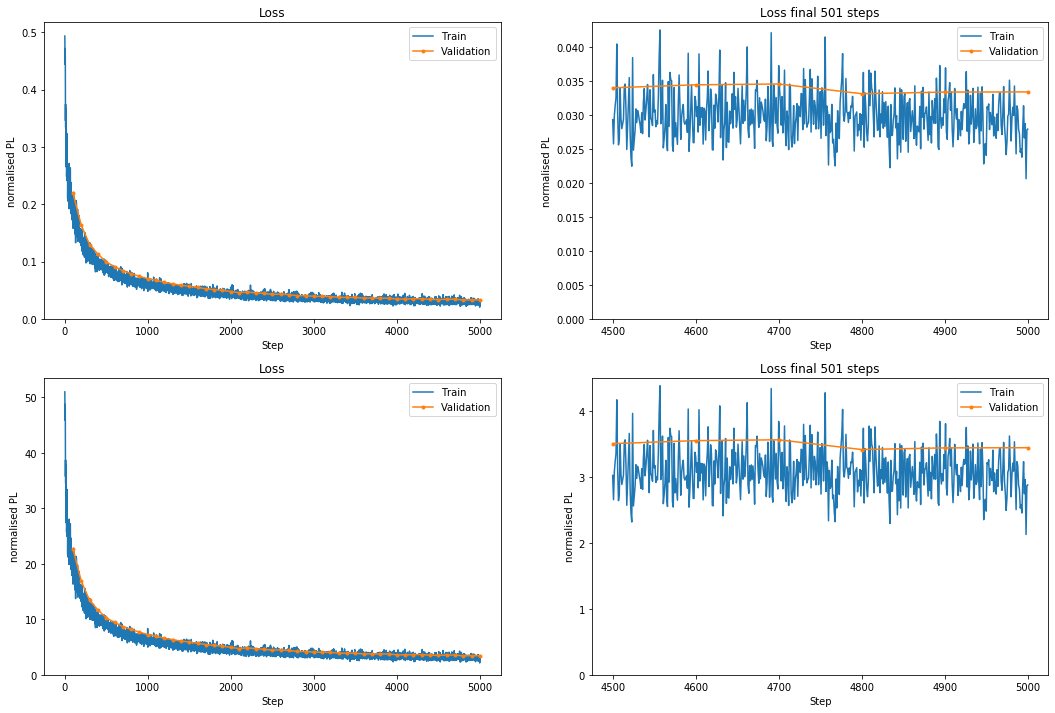

100/100 [==============================] - 9s 93ms/step - loss: 0.0293 - q0_loss: 2.8124e-04 - q1_loss: 0.0010 - q2_loss: 0.0041 - q3_loss: 0.0052 - q4_loss: 0.0067 - q5_loss: 0.0056 - q6_loss: 0.0046 - q7_loss: 0.0013 - q8_loss: 4.1493e-04 - val_loss: 0.0334 - val_q0_loss: 3.3577e-04 - val_q1_loss: 0.0012 - val_q2_loss: 0.0046 - val_q3_loss: 0.0059 - val_q4_loss: 0.0076 - val_q5_loss: 0.0064 - val_q6_loss: 0.0052 - val_q7_loss: 0.0016 - val_q8_loss: 6.1159e-04


In [126]:
history = model.fit(train_batch_creator.flow(), epochs=50,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger4])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{9: 0.16735226464505226, 'WSPL': 0.16735226464505226}


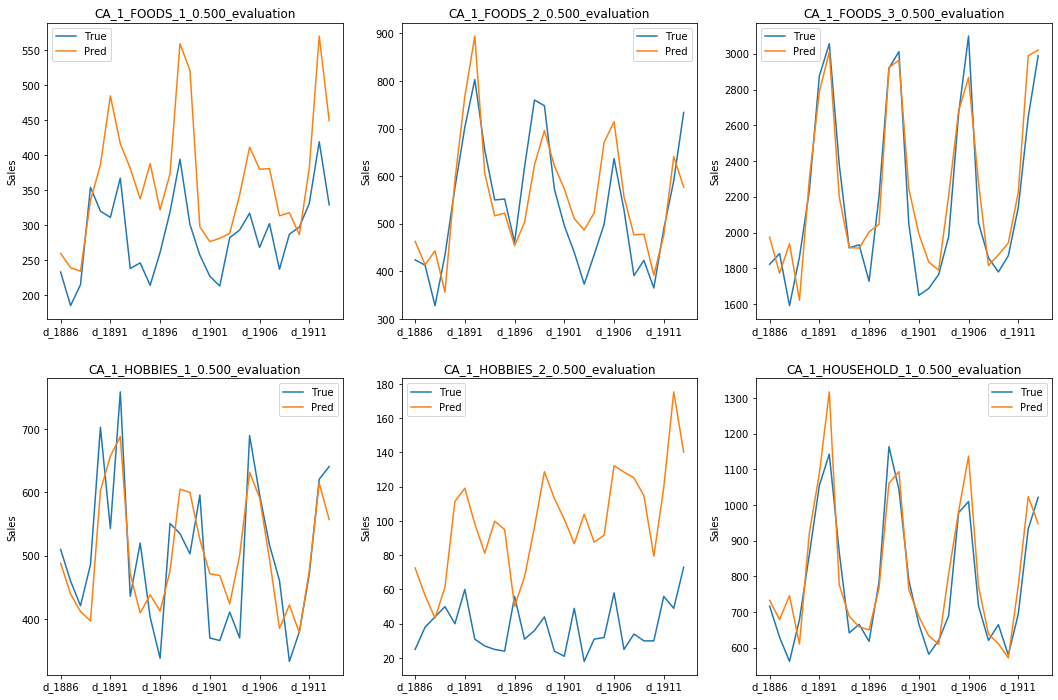

In [127]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

### Test lr

### CLR

In [128]:
from tensorflow.keras.callbacks import LearningRateScheduler

def get_lr_test_scheduler(lr_start, lr_max, num):
    """LR test scheduler function. Ramps up linearly from lr_start to lr_max.
    To be combined with tf.keras.callbacks.LearningRateScheduler"""
    def lr_test_scheduler(epoch, lr):
        lr_range = np.linspace(lr_start, lr_max, num=num)
        lr = lr_range[epoch]
        return lr
    return lr_test_scheduler

epochs = 100
lr_scheduler_func = get_lr_test_scheduler(lr_start=1e-6, lr_max=1e-2, num=epochs)
lr_callback = LearningRateScheduler(lr_scheduler_func, verbose=1)

In [129]:
# setup logger
logger = Logger(val_batch_creator)

# build model
model = get_simple_dist_model(inp_shape=x[0].shape)
model.compile(optimizer=Adam(learning_rate=lr), loss=losses)

# train model
history = model.fit(train_batch_creator.flow(), epochs=epochs,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger, lr_callback])

KeyboardInterrupt: 

In [130]:
def get_pyramid_lr(lr_start=0.01, lr_max=0.5, n_epoch=100, n_epochs_end=10):
    """LR pyramidal scheduler function. Ramps up linearly from lr_start to lr_max,
    then back to lr_start and finished with an additional slope to 1/10th of lr_start.
    To be combined with tf.keras.callbacks.LearningRateScheduler"""
    def lr_pyramid_scheduler(epoch, lr):
        n_epoch_half_pyramid = int(np.ceil(n_epoch/2 - n_epochs_end/2))
        lr_range = np.concatenate((
            np.linspace(lr_start, lr_max, num=n_epoch_half_pyramid),
            np.linspace(lr_max, lr_start, num=n_epoch_half_pyramid),
            np.linspace(lr_start, lr_start/10, num=n_epochs_end)))
        lr = lr_range[epoch]
        return lr
    return lr_pyramid_scheduler

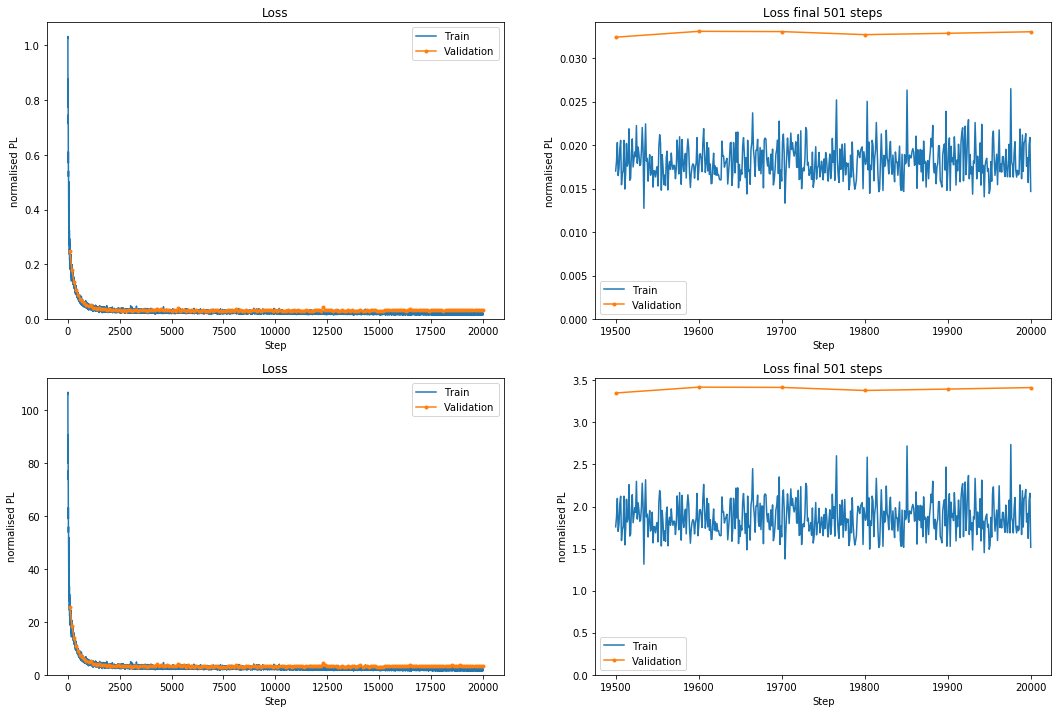

100/100 [==============================] - 8s 78ms/step - loss: 0.0183 - q0_loss: 1.7117e-04 - q1_loss: 6.4268e-04 - q2_loss: 0.0026 - q3_loss: 0.0033 - q4_loss: 0.0043 - q5_loss: 0.0035 - q6_loss: 0.0028 - q7_loss: 7.5797e-04 - q8_loss: 2.4076e-04 - val_loss: 0.0330 - val_q0_loss: 6.3561e-04 - val_q1_loss: 0.0017 - val_q2_loss: 0.0051 - val_q3_loss: 0.0062 - val_q4_loss: 0.0073 - val_q5_loss: 0.0058 - val_q6_loss: 0.0046 - val_q7_loss: 0.0013 - val_q8_loss: 4.8562e-04


In [132]:
epochs = 200
peak_lr = 0.0049
lr_scheduler_func = get_pyramid_lr(lr_start=peak_lr/100, lr_max=peak_lr, n_epoch=epochs)
lr_callback = LearningRateScheduler(lr_scheduler_func, verbose=1)

# setup logger
logger = Logger(val_batch_creator)

# build model
model = get_simple_dist_model(inp_shape=x[0].shape)
model.compile(optimizer=Adam(learning_rate=peak_lr/100), loss=losses)

# train model
history = model.fit(train_batch_creator.flow(), epochs=epochs, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger, lr_callback])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{9: 0.1604578428385204, 'WSPL': 0.1604578428385204}


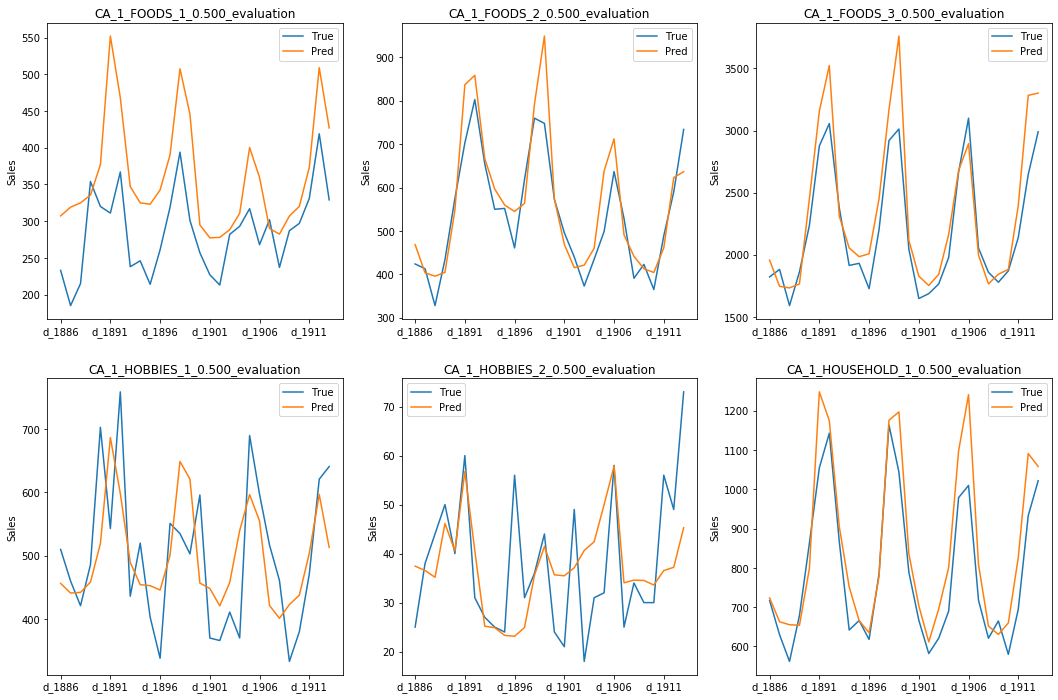

In [133]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

In [134]:
model.save(model_dir + "model_clr.h5")

In [135]:
model.set_weights(logger.best_model)
model.save(model_dir + "model_clr_best_spl.h5")

## Train dense model

In [ ]:
epochs = 200

# setup logger
logger = Logger(val_batch_creator)

# build model
model = get_simple_dense_model(inp_shape=x[0].shape)
model.compile(optimizer=Adam(1e-3), loss=losses)

# train model
history = model.fit(train_batch_creator.flow(), epochs=epochs, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger, lr_callback])

***Bottleneck size***

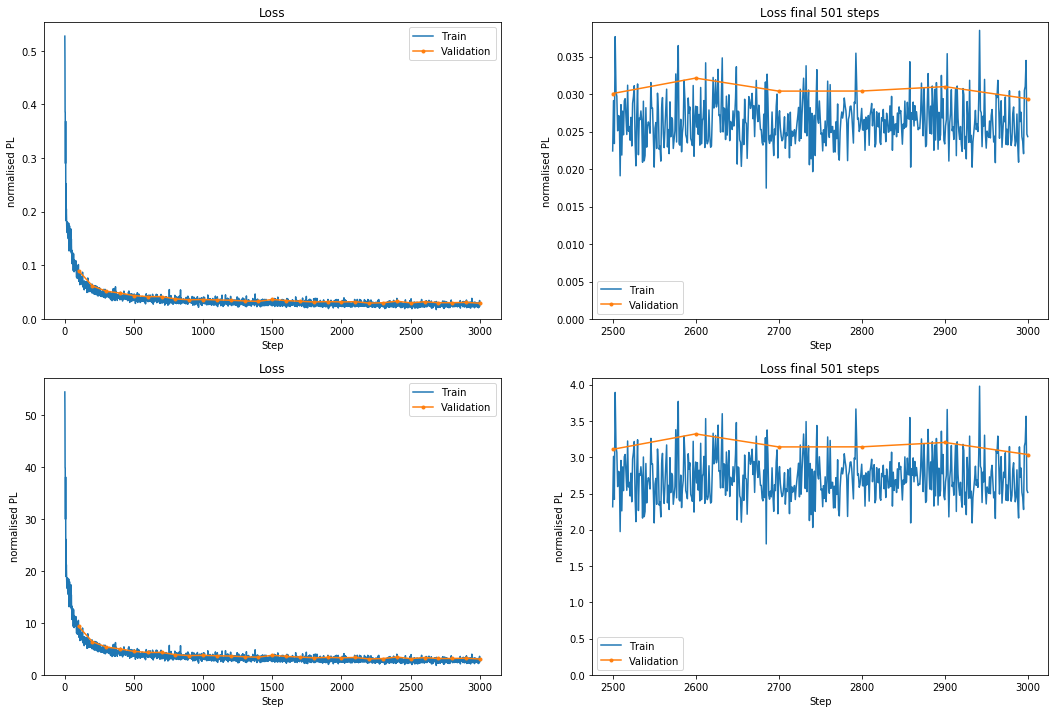

100/100 [==============================] - 7s 69ms/step - loss: 0.0262 - q0_loss: 2.4844e-04 - q1_loss: 8.5477e-04 - q2_loss: 0.0036 - q3_loss: 0.0047 - q4_loss: 0.0061 - q5_loss: 0.0051 - q6_loss: 0.0041 - q7_loss: 0.0012 - q8_loss: 3.6455e-04 - val_loss: 0.0294 - val_q0_loss: 2.5311e-04 - val_q1_loss: 8.8136e-04 - val_q2_loss: 0.0039 - val_q3_loss: 0.0051 - val_q4_loss: 0.0071 - val_q5_loss: 0.0060 - val_q6_loss: 0.0046 - val_q7_loss: 0.0012 - val_q8_loss: 3.1679e-04


In [136]:
options = [2, 4, 8, 16, 32, 64, 128]
logger_list = []

for num_bottleneck in options:
    # setup logger
    logger = Logger(val_batch_creator)
    
    # build model
    model = get_simple_dense_model(inp_shape=x[0].shape, bottleneck_nodes=num_bottleneck)
    model.compile(optimizer=Adam(learning_rate=3e-4), loss=losses)
    
    # train model
    history = model.fit(train_batch_creator.flow(), epochs=30, steps_per_epoch=100,
                        validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                        callbacks=[logger])
    
    # save logger
    logger_list.append(logger)

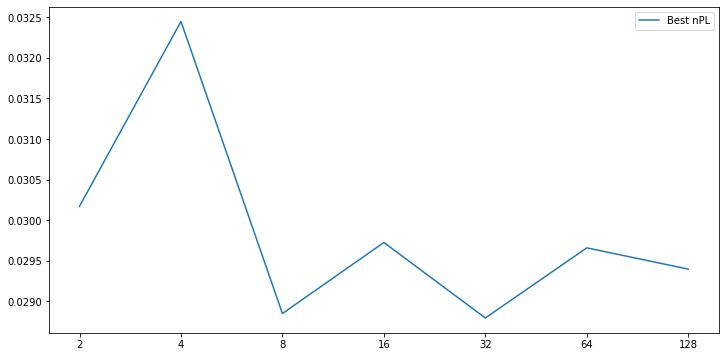

In [149]:
plot_loggers(logger_list, labels=options)

***Batch size***

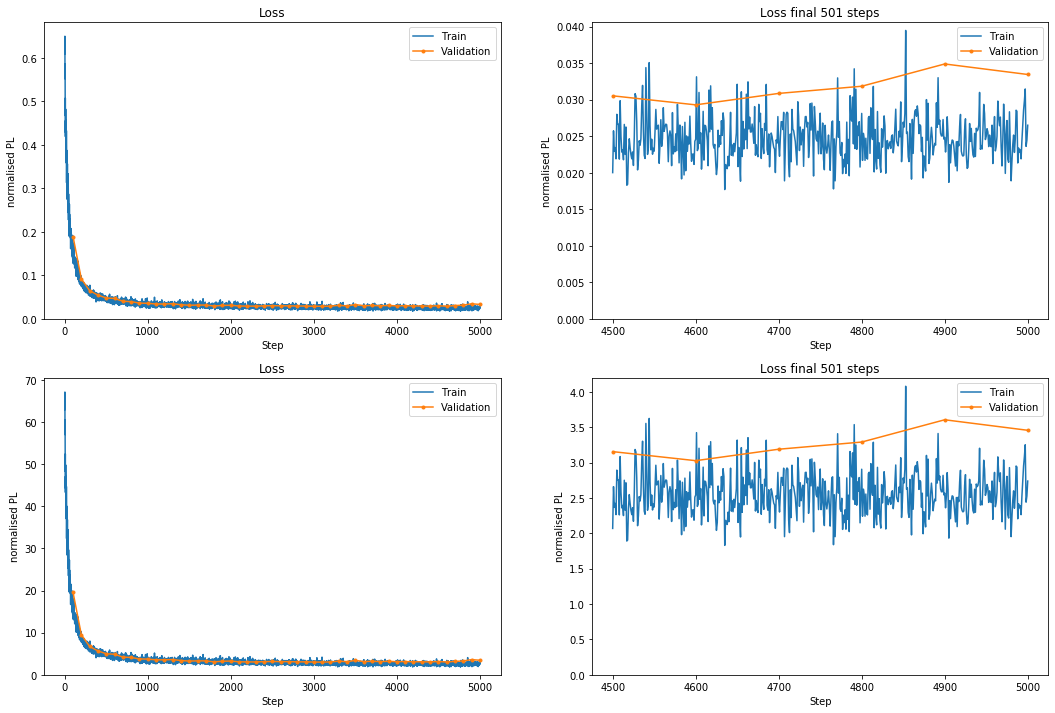

100/100 [==============================] - 8s 82ms/step - loss: 0.0246 - q0_loss: 2.2820e-04 - q1_loss: 8.1846e-04 - q2_loss: 0.0034 - q3_loss: 0.0044 - q4_loss: 0.0057 - q5_loss: 0.0048 - q6_loss: 0.0039 - q7_loss: 0.0011 - q8_loss: 3.0638e-04 - val_loss: 0.0335 - val_q0_loss: 2.5067e-04 - val_q1_loss: 0.0011 - val_q2_loss: 0.0044 - val_q3_loss: 0.0064 - val_q4_loss: 0.0076 - val_q5_loss: 0.0067 - val_q6_loss: 0.0052 - val_q7_loss: 0.0013 - val_q8_loss: 3.6216e-04


In [150]:
options = [64, 256, 1024, 4096, 16384]
logger_list = []

for batch_size in options:
    # setup logger
    logger = Logger(val_batch_creator)
    
    # build model
    model = get_simple_dense_model(inp_shape=x[0].shape, bottleneck_nodes=8)
    model.compile(optimizer=Adam(learning_rate=3e-4), loss=losses)
    
    # train model
    history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                        validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                        callbacks=[logger])
    
    # save logger
    logger_list.append(logger)

In [155]:
def plot_loggers(loggers, labels=None):
    WSPL_list = []
    best_pl_list = []
    for logger in loggers:
        model.set_weights(logger.best_model)
        metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level,
                                    verbose=False)
        WSPL_list.append(metrics['WSPL'])
        best_pl_list.append(logger.best_spl)
    
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(WSPL_list, label="WSPL")
    # ax.plot(best_pl_list, label="Best nPL")
    if labels is not None:
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels)
    ax.legend()
    plt.show()

Predicting...
Denormalising...
Warping predictions...
Predicting...
Denormalising...
Warping predictions...
Predicting...
Denormalising...
Warping predictions...
Predicting...
Denormalising...
Warping predictions...
Predicting...
Denormalising...
Warping predictions...


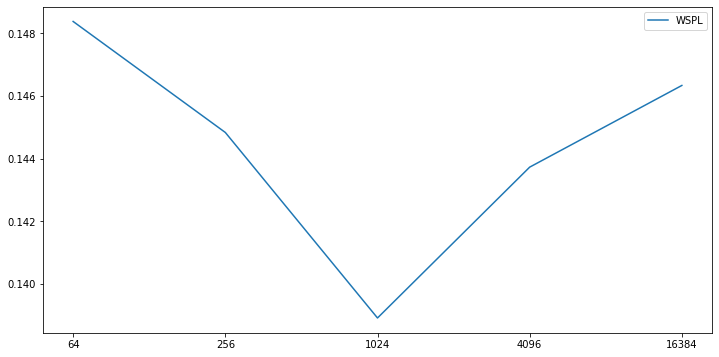

In [156]:
plot_loggers(logger_list, labels=options)

In [158]:
model.set_weights(logger_list[2].best_model)
model.save(model_dir + "model_bs.h5")